# Práctica 1. Fundamentos Análisis

Daniel Pérez Efremova 

Santiago Juan Queipo de Llano

En esta práctica, se hace una auditoría de los datos del banco para tomar una visión de los datos de cara al desarrollo de un modelo de optimización del proceso de ventas de depósitos bancarios.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import missingno as msn

In [ ]:
def piechart(serie): # función para hacer gráficos en tarta
    
    value_counts = serie.value_counts() # se cogen las frecuencias y nombres de los valores
    
    labels = value_counts.index.tolist() 
    sizes = value_counts.values.tolist() 
    
    fig1, ax1 = plt.subplots(figsize=(7, 7))
    ax1.pie(sizes, labels=labels, autopct='%1.2f%%')
    ax1.axis('equal') 
    plt.title(f'Distribución de "{serie.name}"')
    plt.show()
    
    return None

### Lectura de los datos desde el csv

Se ve en la documentación que los valores missing se indican con distintos valores como ?, unknown o 999. Se pasan como argumetno esos valoresa a la función de lectura de pandas.

In [ ]:
data = pd.read_csv('bank-additional-full.csv', na_values=['?', 'unknown', '999'], sep=';')
#/content/sample_data/bank-additional-full.csv

### Resumen de los datos. Tipo y número de valores perdidos. Dimensiones de los datos.

In [ ]:
pd.DataFrame([data.dtypes, data.isnull().sum()], index=['dtype', '#nulls']).transpose()

,dtype,#nulls
age,int64,0
job,object,330
marital,object,80
education,object,1731
default,object,8597
housing,object,990
loan,object,990
contact,object,0
month,object,0
day_of_week,object,0


In [ ]:
data.shape

(41188, 21)

Se agrupan las variables categóricas y numéricas en dos listas para tratamientos posteriores.

In [ ]:
numeric_cols = data.select_dtypes(include=np.number).columns
object_cols = set(data.columns) - set(numeric_cols)

In [ ]:
numeric_cols

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [ ]:
bins = [min(data['age']), 25,  65, max(data['age'])]
data['age_binned'] = pd.cut(data['age'], bins)
data['age_binned'].value_counts() # ejercicio 8

(25, 65]    38903
(17, 25]     1661
(65, 98]      619
Name: age_binned, dtype: int64

### 1. Descripción de las variables y valores estadísticos (mínimo, máximo, media, desviación, mediana, etc.). Estudia qué valores estadísticos son los convenientes según el tipo de variable y procede en consecuencia.

En primer lugar, se realiza una primera inspección de los datos que incluye el dataset.

In [ ]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_binned
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"(25, 65]"
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"(25, 65]"
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"(25, 65]"
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"(25, 65]"
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"(25, 65]"


Para esta parte se usa la función de pandas .describe(). 

Para las variables numéricas se utilizan los estadísticos:

- media
- std
- mínimo
- máximo
- cuartiles

Para las variables categóricas se utilizan los estadísticos:

- count: numero de valores que no son null en la variable.
- unique: cuántos valores distintos toma la variable.
- top: el valor más frecuente
- freq: frecuencia absoluta del valor más frecuente.

In [ ]:
data.describe(include='all').transpose().sort_values(by='unique')

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
default,32591,2,no,32588,NaN,NaN,NaN,NaN,NaN,NaN,NaN
housing,40198,2,yes,21576,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,40198,2,no,33950,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,41188,2,cellular,26144,NaN,NaN,NaN,NaN,NaN,NaN,NaN
y,41188,2,no,36548,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,41108,3,married,24928,NaN,NaN,NaN,NaN,NaN,NaN,NaN
poutcome,41188,3,nonexistent,35563,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age_binned,41183,3,"(25, 65]",38903,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day_of_week,41188,5,thu,8623,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,39457,7,university.degree,12168,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Se pintan a continuación diferentes Piecharts  para ver las distintas frecuencias de las variables categóricas.

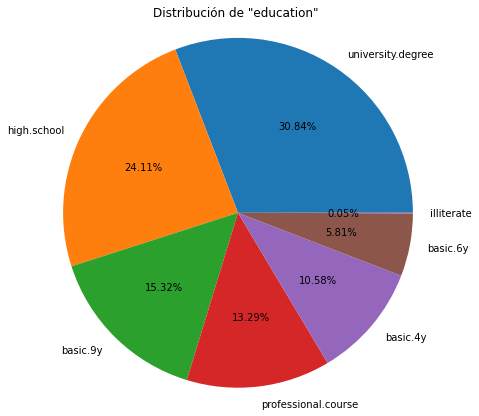

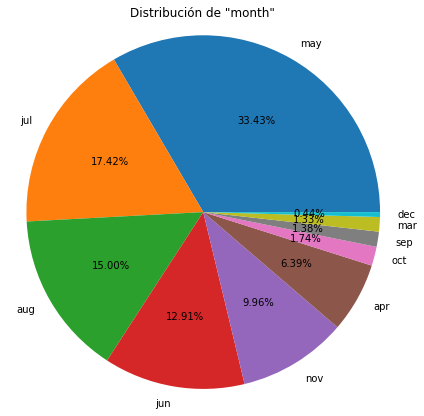

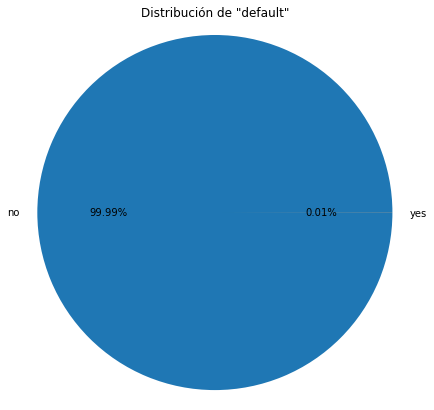

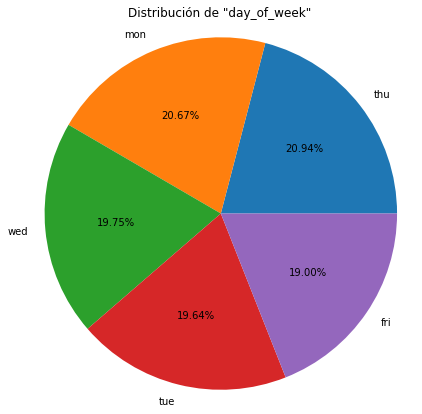

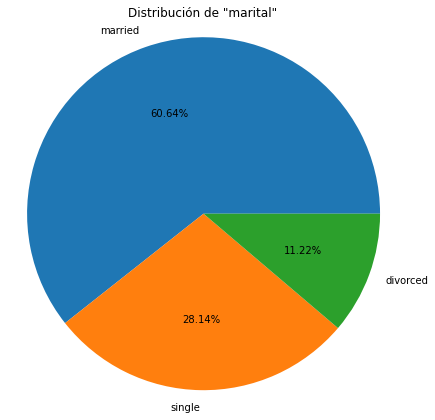

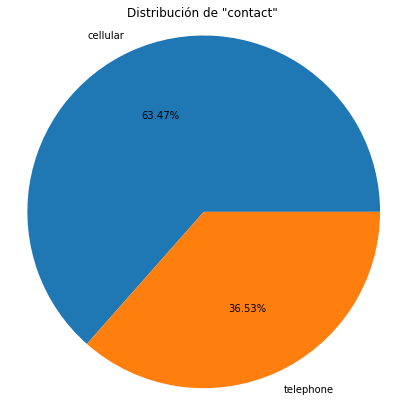

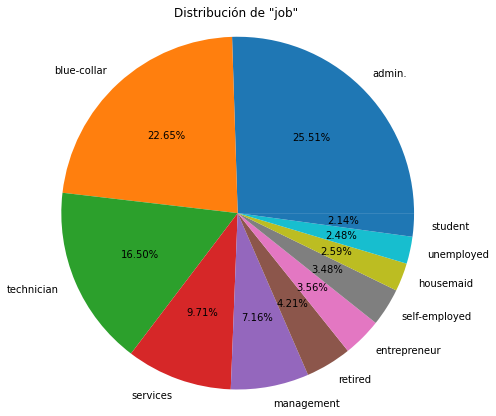

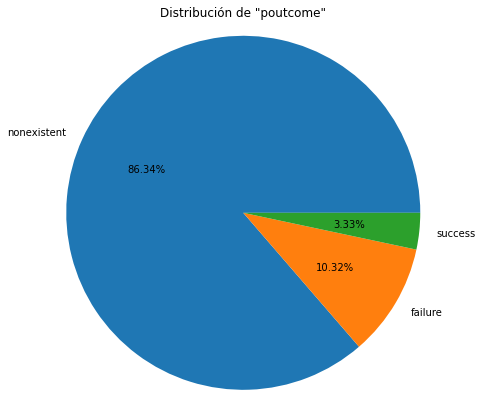

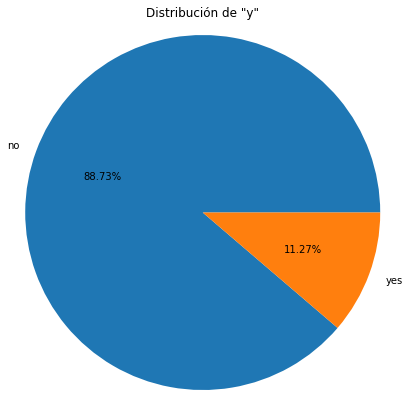

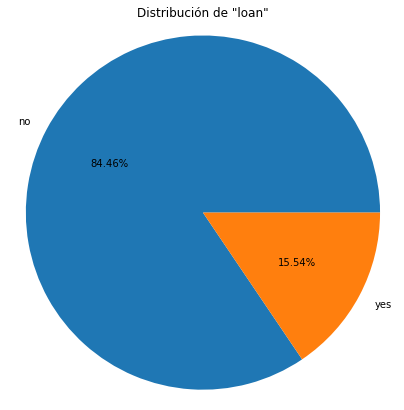

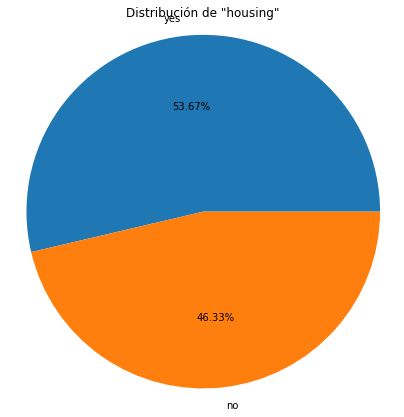

In [ ]:
for col in object_cols:
    piechart(data[col])

Se observa que la variable default no aporta información, la frecuencia relativa de las personas contactadas que hacen default es del 0.01%. La variable Y, la que se supone como el output o salida del modelo, presenta una frecuencia relativa muy desfavorable para los Yes. Cuando lo ideal o esperado debería ser una proporción 50-50 (de Yes-No) para poder entrenar adecuadamente el modelo.

Por otro lado, se hace un gráfico de la función de densidad de las variables numéricas para entender su distribución, detectar posibles incosistencias y decidir qué transformaciones se pueden realizar en pasos posteriores.

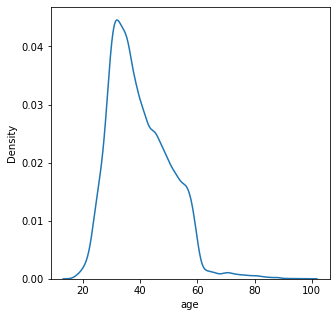

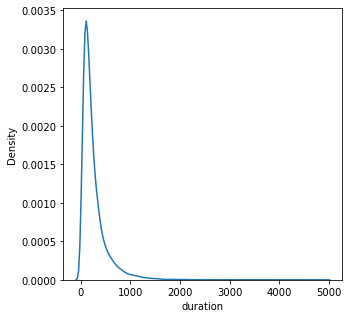

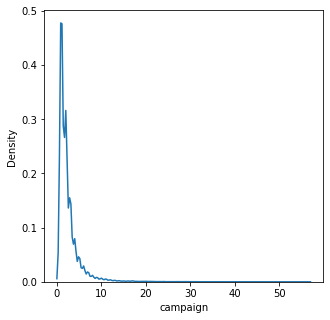

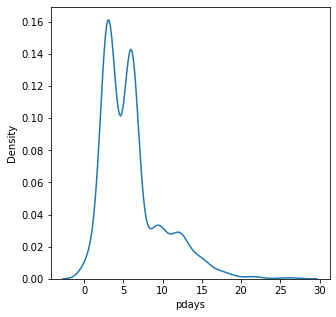

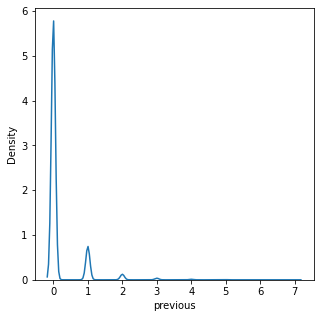

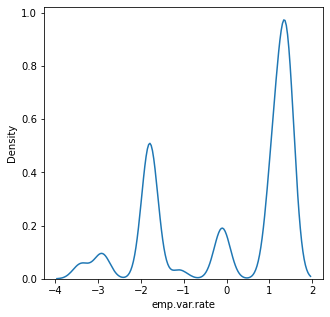

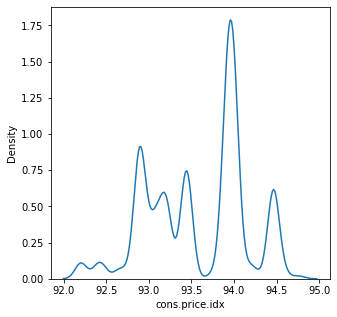

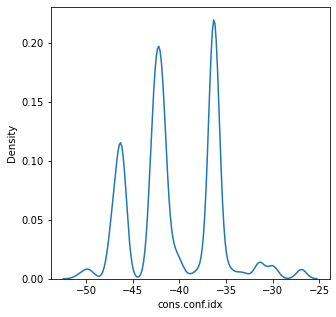

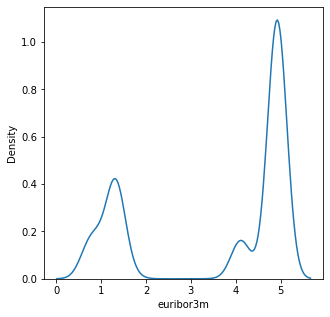

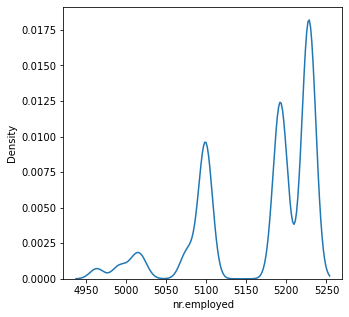

In [ ]:
for col in numeric_cols:
    plt.figure(figsize=(5, 5))
    sns.kdeplot(data=data.loc[:, col])
    plt.show()

Se observa que las variables duración y campaign tienen una distribución fuertemente asimétrica hacia la derecha, se puede hipotetizar que sigue una ley potencia. Además, en general, se observa que las distribuciones son mixturas de distribuciones, algo a tener en cuenta para la posible creación de variables sintéticas mediante técnicas de clustering.

# 2 Describe y realiza modificaciones en la base datos si lo consideras necesario. Por ejemplo, qué harías con valores nominales, si los hubiera.

1. Crear dummies para las variables categoricas
2. Borrar la variable default (pocos casos, nada de info)
5. nr.employed pasarlo a categorica

### 2.1 Creación de ID de cliente

Se ha observado que el dataset no incluye ningún campo que identifique de forma única las filas.  Algo muy practico a la hora de realizar comprobaciones sobre los datos o realizar pruebas.  El identificador es simplemente un contador que incrementa en uno por cada fila del dataset.

In [ ]:
data['id'] = range(len(data)) # creacion del id

In [ ]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,age_binned,id
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"(25, 65]",0
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"(25, 65]",1
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"(25, 65]",2
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"(25, 65]",3
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,"(25, 65]",4


### 2.2 Eliminación de la variable default

Como se ha explicado en el punto anterior, la variable default resulta irrelevante para el modelo y no añade información significativa.

In [ ]:
data.drop('default', axis=1, inplace=True)
object_cols.discard('default')

### 2.3 Conversión de nr.employees a tipo entero

Se ha observado que la variable nr.employed incluye un decimal. Esto puede ser a que se ha querido adaptar la magnitud de numero de trabajadores al tamaño de la muestra. Si la muestra contaba con el 10% de todos los casos, el numero de empleados se ha dividido entre 10 para preservar algun tipo de relación numérica. Para solventar los decimales, se redondea pasando el numero a entero.

In [ ]:
data['nr.employed'] = data['nr.employed'].astype(int)

### 2.4 Sustitución del caracter "." por "_" en la columna education

Se ha transformado la variable education, para sustituir en las categorías los puntos por guiones bajos. Así se puede aprovechar la funcionalidad de llamar a las columnas del dataset como atributos del objeto pandas.DataFrame y por razones de seguridad.

In [ ]:
data['education'] = data['education'].apply(lambda x: x.replace('.', '_') if isinstance(x, str) else x)

### 2.5 Transformación de los valores de las variables bool a 0 y 1

# 3. Estudia si es necesario normalizar los datos y cómo lo harías. Procede a modificar la base de datos (normalizar) si lo consideras necesario.

Ordenando el resumen de las variables por el valor del máximo, se ve que las variables numéricas tienen escalas muy distintas, con una diferencia de 3 órdenes de magnitud. Para poder comparar dichas magnitudes se deberían estandarizar. Por otro lado, para buscar outliers convendría tener los valores en una escala que permita aplicar test estadísticos.

Por lo general se deberían normalizar únicamente las variables que interesen a la hora de definir un modelo, en este caso, como se desconoce el uso final que se va a dar dichas variables, se decide normalizar todas las variables numéricas.

In [ ]:
data.describe(include='all').transpose().sort_values(by=['max'], ascending=False)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,41188.0,NaN,NaN,NaN,20593.5,11890.09578,0.0,10296.75,20593.5,30890.25,41187.0
nr.employed,41188.0,NaN,NaN,NaN,5166.849446,72.328375,4963.0,5099.0,5191.0,5228.0,5228.0
duration,41186.0,NaN,NaN,NaN,258.249041,259.234158,0.0,102.0,180.0,319.0,4918.0
age,41188.0,NaN,NaN,NaN,40.02406,10.42125,17.0,32.0,38.0,47.0,98.0
cons.price.idx,41188.0,NaN,NaN,NaN,93.575664,0.57884,92.201,93.075,93.749,93.994,94.767
campaign,41188.0,NaN,NaN,NaN,2.567593,2.770014,1.0,1.0,2.0,3.0,56.0
pdays,1515.0,NaN,NaN,NaN,6.014521,3.824906,0.0,3.0,6.0,7.0,27.0
previous,41188.0,NaN,NaN,NaN,0.172963,0.494901,0.0,0.0,0.0,0.0,7.0
euribor3m,41188.0,NaN,NaN,NaN,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
emp.var.rate,41188.0,NaN,NaN,NaN,0.081886,1.57096,-3.4,-1.8,1.1,1.4,1.4


In [ ]:
scaler = StandardScaler()
scaler.fit(data.loc[:, numeric_cols])
data.loc[:, numeric_cols] = scaler.transform(data.loc[:, numeric_cols])

In [ ]:
data.describe(include='all').transpose().sort_values(by=['max'], ascending=False)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,41188.0,NaN,NaN,NaN,20593.5,11890.09578,0.0,10296.75,20593.5,30890.25,41187.0
campaign,41188.0,NaN,NaN,NaN,0.0,1.000012,-0.565922,-0.565922,-0.204909,0.156105,19.289818
duration,41186.0,NaN,NaN,NaN,0.0,1.000012,-0.996212,-0.602741,-0.301851,0.234351,17.975284
previous,41188.0,NaN,NaN,NaN,0.0,1.000012,-0.349494,-0.349494,-0.349494,-0.349494,13.794918
age,41188.0,NaN,NaN,NaN,0.0,1.000012,-2.209365,-0.76998,-0.194227,0.669404,5.56331
pdays,1515.0,NaN,NaN,NaN,-0.0,1.00033,-1.572982,-0.78839,-0.003798,0.257733,5.488346
cons.conf.idx,41188.0,NaN,NaN,NaN,-0.0,1.000012,-2.224953,-0.474791,-0.280328,0.886447,2.939106
cons.price.idx,41188.0,NaN,NaN,NaN,-0.0,1.000012,-2.374889,-0.864955,0.299457,0.722722,2.058168
nr.employed,41188.0,NaN,NaN,NaN,0.0,1.000012,-2.818423,-0.938086,0.333906,0.845468,0.845468
emp.var.rate,41188.0,NaN,NaN,NaN,-0.0,1.000012,-2.216433,-1.197935,0.648092,0.839061,0.839061


Se observa que las varibales despues de la transformacion se pueden comparar más facilmente al tener la misma escala. Por otro lado, por sencillez, se ha ajustado el estandarizador sobre toda la matriz de datos en lugar de sobre cada columna, algo que puede limitar el uso de la estandarización.

# 4. Detección de valores extremos (outliers) y descripción de qué harías en cada caso.

Revisitar esta sección.

En un primer momento, es necesario aclarar que en este punto unicamente se deberan tener en cuenta las variables numerica ya que son las que presentaran valores extremos. 

A continuación, se van a mostrar los diferentes boxplot de las variables numericas.

<AxesSubplot:>

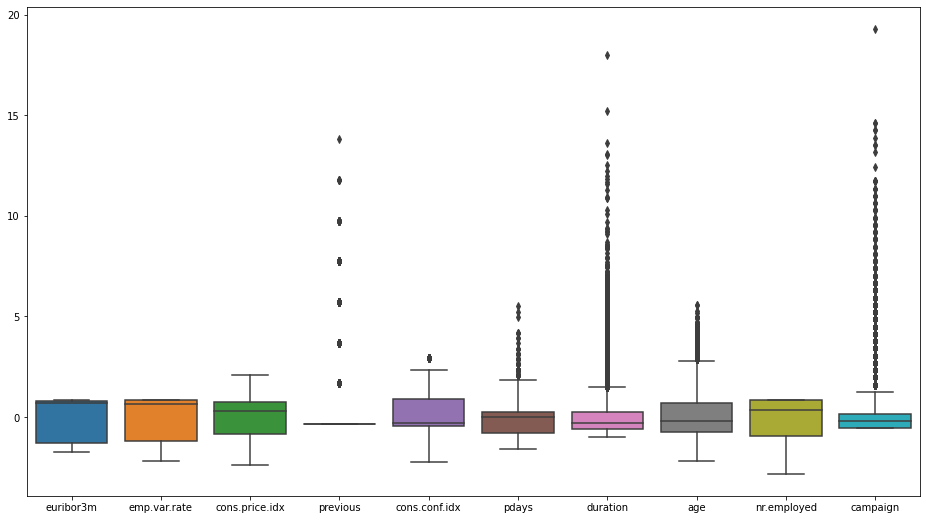

In [ ]:
plt.figure(figsize=(16, 9))
sns.boxplot(data=data.loc[:, set(numeric_cols)-set('id')])

Como se puede observar las variables que presentan mayor número de valores atipicos son pdays, duration, previous y campaign.

Tener valores atipicos no indica que sean descartables pero es necesario estudiar con mayor atención.

Se han presentado las distribuciones de las diferentes variables numericas.

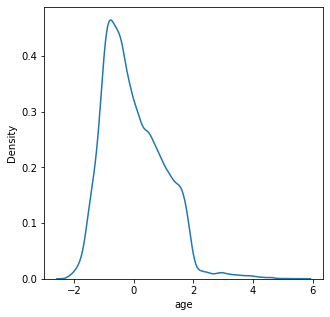

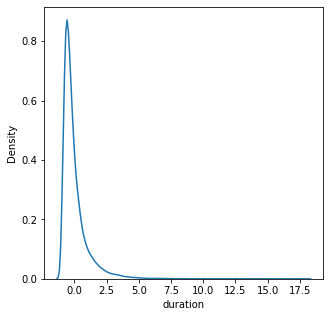

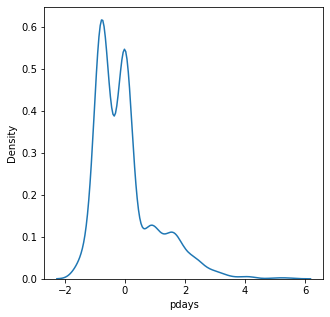

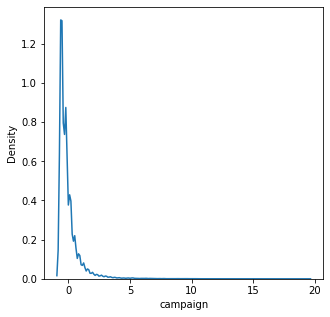

In [ ]:
selected_cols = ['age', 'duration', 'pdays', 'campaign']

for col in selected_cols:
    plt.figure(figsize=(5, 5))
    sns.kdeplot(data=data.loc[:, col])
    plt.show()

In [ ]:
for col in selected_cols:
    IQR=data[col].quantile(.75)-data[col].quantile(.25) 
    maxValorTipico=(data[col].quantile(.75)+1.5*(IQR))
    minValorTipico=(data[col].quantile(.25)-1.5*(IQR))
    data[f"{col}_outlier"] = (data[col]<minValorTipico) | (data[col]>maxValorTipico)
    data[f"{col}_outlier"] = data[f"{col}_outlier"].astype(int)
    print(data[f"{col}_outlier"].value_counts())

0    40719
1      469
Name: age_outlier, dtype: int64
0    38227
1     2961
Name: duration_outlier, dtype: int64
0    41106
1       82
Name: pdays_outlier, dtype: int64
0    38782
1     2406
Name: campaign_outlier, dtype: int64


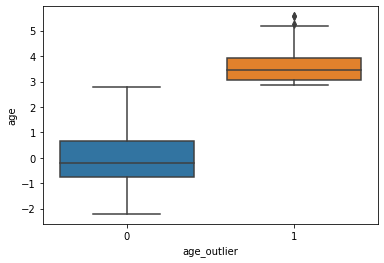

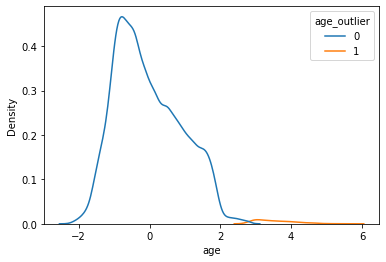

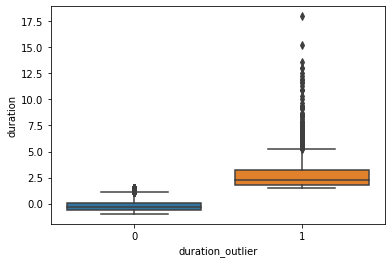

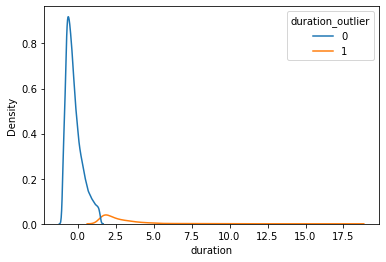

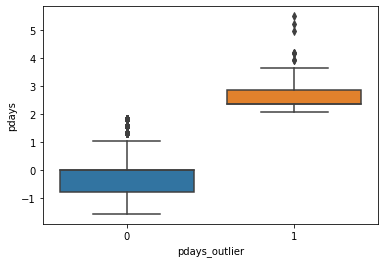

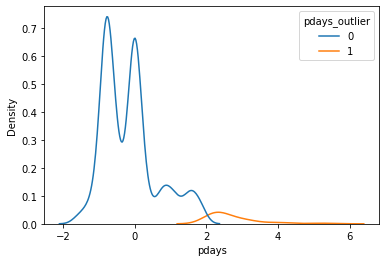

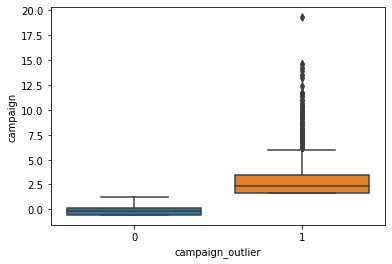

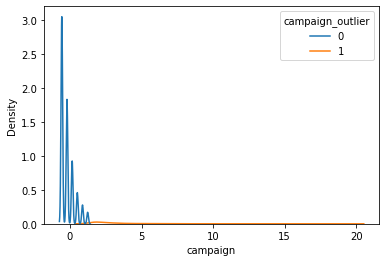

In [ ]:
for col in selected_cols:

    sns.boxplot(data=data, y=f'{col}', x=f'{col}_outlier')
    plt.show()
    sns.kdeplot(data=data, x=f'{col}', hue=f'{col}_outlier')
    plt.show()

In [ ]:
for col in selected_cols:

    print(pd.crosstab(data[f'{col}_outlier'], data['y'], normalize='index'))
    print('\n\n')

y                  no       yes
age_outlier                    
0            0.891476  0.108524
1            0.528785  0.471215



y                       no       yes
duration_outlier                    
0                 0.918513  0.081487
1                 0.484971  0.515029



y                    no       yes
pdays_outlier                    
0              0.888264  0.111736
1              0.426829  0.573171



y                       no       yes
campaign_outlier                    
0                 0.883219  0.116781
1                 0.953865  0.046135





Se puede observar que para las variables age, duration, campaign existen un número considerable de outliers. Sobre estas variables se han sacado los outliers considerados por el IQR. El resultado en la clase de outliers la salida "y" es aproximadamente 50-50 y que para los valores normales la salida es 90% No 10% Yes. 

# 5. Detección de valores perdidos (missing values) y descripción de cómo actuarías para solventar el problema.

En este apartado se va a realizar un analisis de los valores perdidos.

En primer lugar, para detectar valores perdidos usamos la libreria missingno para ver la cantidad de outliers, y si estan correlacionados en la siguiente gráfica. 

<AxesSubplot:>

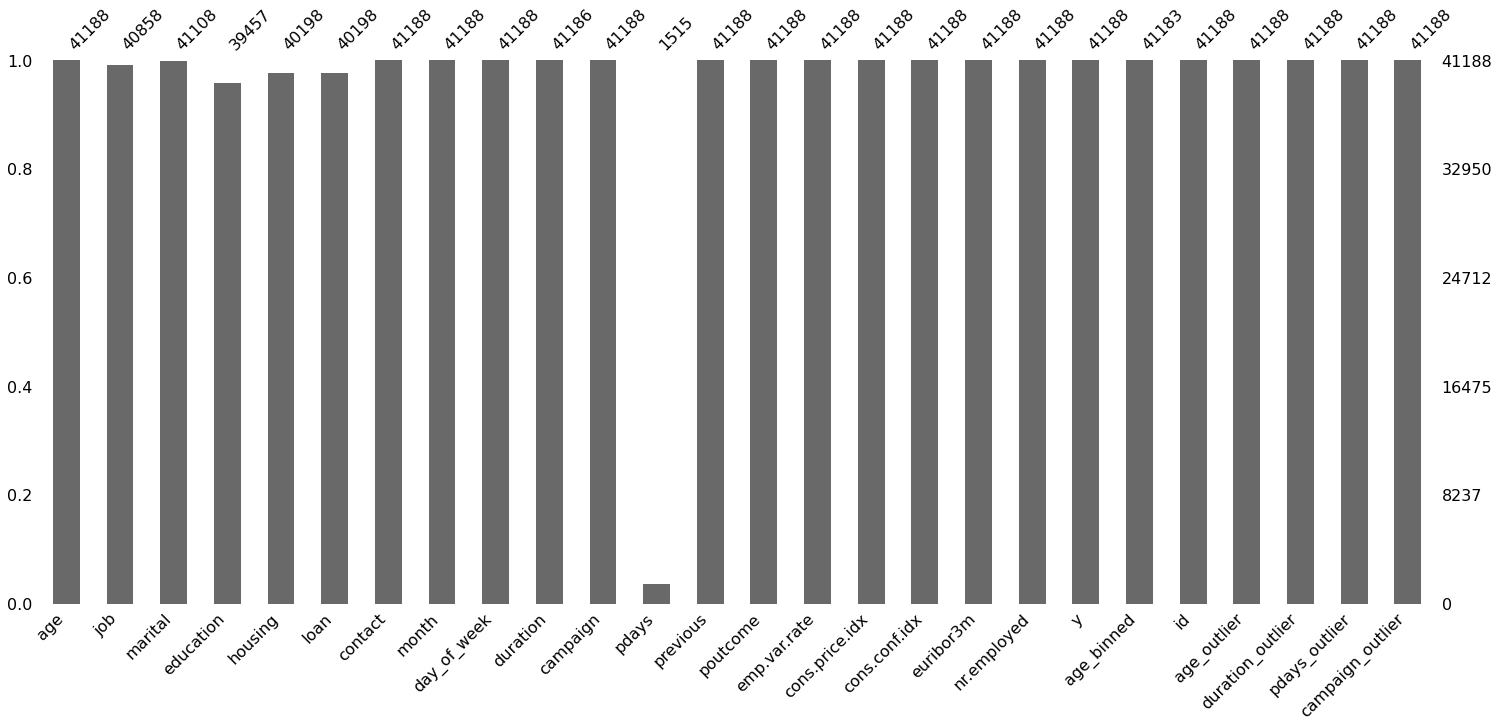

In [ ]:
msn.bar(data)

Se puede ver que la mayoria de variables no presentan missing values. La más llamativa es pdays, pero porque se han cosiderado missing aquellos que presentaban un 999 como pdays (999 significaba que no se habia contactado previamente)

En segundo lugar se quiere observar si existe una correlación de missings entre variables, es decir, si los missings de dos variables suceden en los mismos casos.

<AxesSubplot:>

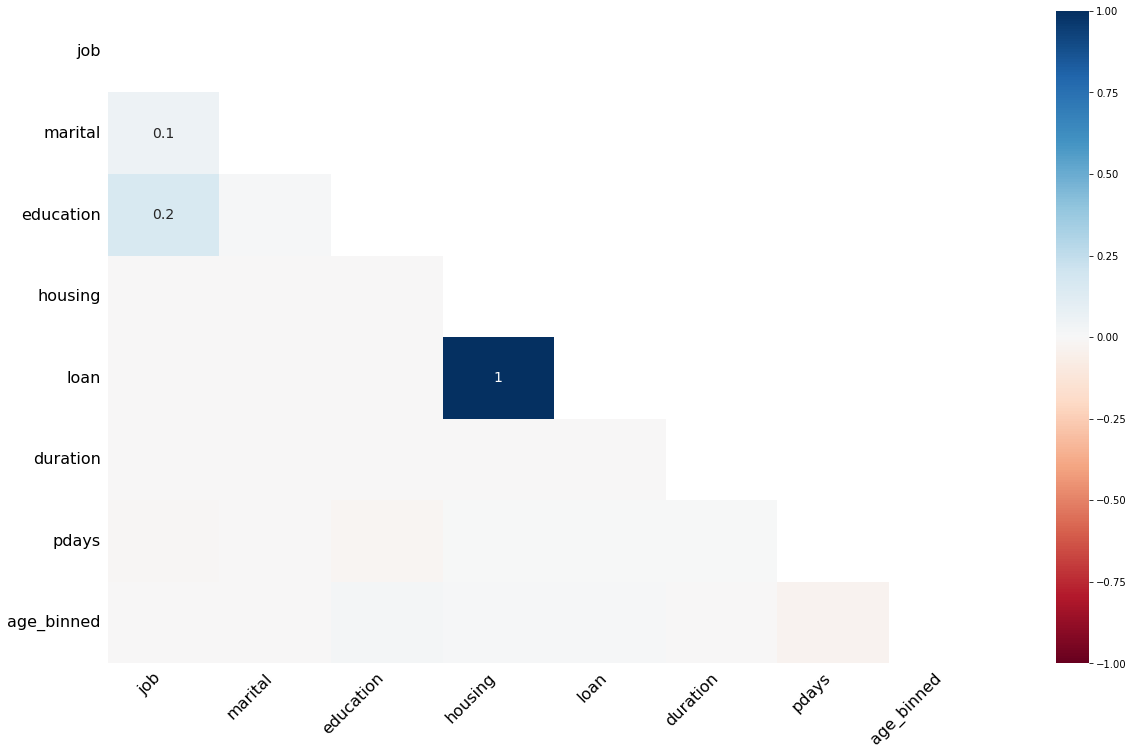

In [ ]:
msn.heatmap(data)

Se observa que pdays tiene una gran cantidad de valores perdidos (fruto de la transformación anterior) por lo que no se incluirá en el rellenado de datos. Por otro lado  se ve que cuando la variable loan se pierde, tambien se pierde housing. Además, se ve que la cantidad de valores perdidos es pequeña, por lo que se pueden emplear técnicas sencillas para el rellenado como usar la media o la moda global de la variable. 

Cabe tener en cuenta que:
1. Se podría afinar más el rellenado de datos estudiando alguna posible segmentación para calcular dichos estadísticos. 
2. Se podrían usar modelos de ML particularizados al problema de rellenado de datos faltantes como:
- DBSCAN
- Elliptic Envelope and Minimum Covariance Determinant
- Isolation Forest
- Local Outlier Factor
- One-Class Support Vector Machine

Para aquellos valores que eran nulos se ha aplicado la media a las variables numericas (duration) y la moda a las variables categóricas(marital,education,job,loan y housing).

In [ ]:
replace_with_mean = ['duration']
replace_with_mode = ['marital', 'education', 'job', 'loan', 'housing']

for col in replace_with_mean:

    data[col] = data[col].fillna(data[col].mean())

for col in replace_with_mode:
    data[col] = data[col].fillna(data[col].mode()[0])

Si se vuelve a observar el resumen de nulls ya no se observan casos, salvo en pdays como se ha explicado con anterioridad.

In [ ]:
pd.DataFrame(data.isnull().sum(), columns=['#misssings'])

,#misssings
age,0
job,0
marital,0
education,0
housing,0
loan,0
contact,0
month,0
day_of_week,0
duration,0


En conclusión, las variables que presentaban valores null, se han sustituido las categóricas por la moda y las numéricas por la media. La variable pdays realmente es como sino tuviera outliers porque no se ha perdido información. 

# 6. Buscar correlaciones entre:
    ◦ las variables predictoras, lo que permitirá ver si hay variables redundantes.
    ◦ variables predictoras y la clase (target).

En el siguiente apartado, se quiere investigar las correlaciones que existen entre las diferentes variables numericas y categoricas. 

## Variables numéricas

Para las variables numericas se realiza un heatmap para buscar correlaciones entre las diferentes variables numericas. 

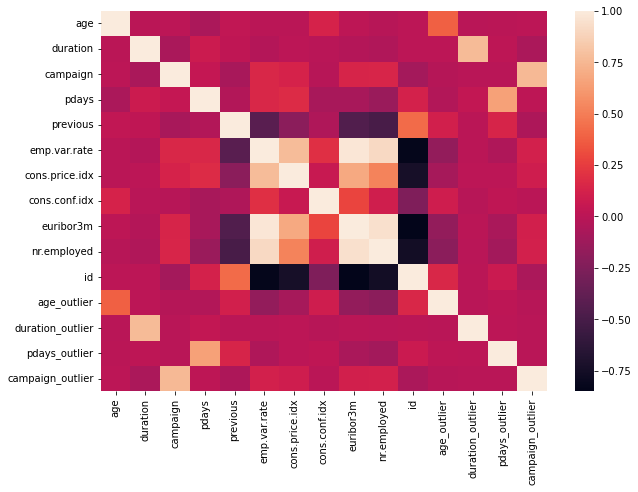

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(data.corr())
plt.show()

Se observa que entre las variables numericas solo existen correlaciones espureas, esto es, no existe evidencia de correlación razonable entre ellas para sustituir unas por otras. Pero si es algo a tener en cuenta a la hora de definir modelos, para evitar la colinealidad.

## Variables categóricas

Para las variables categóricas se estudian las correlaciones que existen entre ellas utilizando el estadistico del chi cuadrado y se observa en el heatmap las correlaciones existentes

In [ ]:
from scipy.stats import chi2_contingency

In [ ]:
df = data.loc[:, object_cols]

In [ ]:
factors_paired = [(i,j) for i in df.columns.values for j in df.columns.values] 

chi2, p_values =[], []

for f in factors_paired:
    if f[0] != f[1]:
        chitest = chi2_contingency(pd.crosstab(df[f[0]], df[f[1]]))   
        chi2.append(chitest[0])
        p_values.append(chitest[1])
    else:      # for same factor pair
        chi2.append(0)
        p_values.append(0)

p_values = np.array(p_values).reshape((10,10)) # shape it as a matrix
p_values = pd.DataFrame(p_values, index=df.columns.values, columns=df.columns.values) # then a df for convenience

<AxesSubplot:>

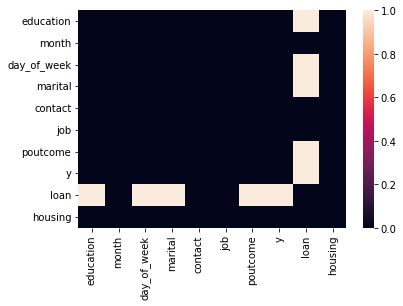

In [ ]:
sns.heatmap(p_values>0.1)

Se observa que existe una depencia fuerte con la variable loan, es posible que la variable loan haya que descartarla por estar en general correlacionada con el resto

# 7. Detecta, si hubiera, falsos predictores.

Se propone como falsos predictores las variables macroeconomicas. Segun la documentación, son variables que se conocen trimestralmente en un periodo posterior a la fecha en que se quiere predecir la venta de depósito. Dada la complejidad que presentan estos indicadores, son dificilmente aplicables a una situación real de predicción, salvo que se dispongan de modelos para tal fin que alimenten el modelo principal de venta de depósitos.

# 8. Estudia si fuera conveniente segmentar alguna de las variables.

Se estudia crear alguna variable categorica a través de las numericas. 

2. Crear categorica con la edad
3. pdays: Con contacto y sin contacto

Se crea la variable age_binned. Se segmenta por edades en: joven(0-25 años), adulto(25-65), 3ª edad(65+). El código se hace al inicio para evitar estandarizar antes de aplicar los valores de corte para formar los intervalos. UNa vez estadarizados no se puede dar un valor intuitivo a los cortes.

In [ ]:
data['age_binned'].value_counts()

(25, 65]    38903
(17, 25]     1661
(65, 98]      619
Name: age_binned, dtype: int64

Se crea la variable contact que indica si se ha establecido contacto previamente (aquellos valores que anteriormente valían 999 pasan a valer 0 y el resto de valores pasa a valer 1) 

In [ ]:
data['contact'] = ~data['pdays'].isnull()

In [ ]:
data['contact'].value_counts()

False    39673
True      1515
Name: contact, dtype: int64

# 9. Estudia si fuera conveniente crear nuevas variables sintéticas basada en las variables originales.

- Si es poblacion activa, población no activa.
- Sin educacion o con educacion

Se crea una variable active que divide la clase trabajadores en activos o no activos, siendo no activos los retirados, estudiantes, desempleados, am@s de casa y activos todos los demás. 

In [ ]:
active = ['services', 'admin.', 'blue-collar', 'technician', 'management', 'self-employed',
       'entrepreneur']

In [ ]:
data['active'] = data['job'].isin(active)

Se crea una variable basic_education que tiene valor true para aquellos que presentan una educación nula o básica. 

In [ ]:
basic_education = ['basic_4y', 'basic_6y', 'basic_9y', 'illiterate']

In [ ]:
data['basic_education'] = data['education'].isin(basic_education)

## Conclusiones

Se ha observado que en la muestra no se mencionan fechas ni marcas temporales, una caracteristica realmente util de la que se puede obtener mucha información. Por ejemplo, el numero de depositos encajados a los clientes no sera igual antes que despues de la crisis de 2008.

Realmente la practica se presenta muy interesante, pero es dificil determinar donde esta el limite y hasta donde se tiene que llegar en cada pruebla o sección. Por otro lado, muchas veces uno se encuentra queriendo resolver cuetiones que podrian pertenecer a diferentes apartados o por el contrario no saber concretamente donde encajarlo. 


- Revisar correlaciones de housing con el resto de variables